<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="https://gei.insa-toulouse.fr/fr/index.html" ><img src="https://gei.insa-toulouse.fr/_contents/ametys-internal%253Asites/dgei/ametys-internal%253Acontents/accueil-entete-de-page-d-accueil/_attribute/header%5B1%5D/header-illustration/image/GEI1.jpg?objectId=defaultWebContent://a9e49303-df60-47de-ab70-5ddb981c9d08" style="max-width: 150px; display: inline;" alt="Département GEI"/> </a>
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right;max-width: 150px; display: inline;"  alt="Wikistat"/> </a>
     
</center>

# Smart cameras to support biodiversity - The tetrao urogallus case

<h3> <i> Image classification  on presence or absence of bird dataset.</i> </h3>

## Summary

The following code is highly inspired by the tutorial taught at INSA in the mathematics departement, which can be found at the following link : https://github.com/wikistat/High-Dimensional-Deep-Learning. This code will then be implemented on FPGA.

## Objectives

The objective of the project is to preserve biodiversity. We focus on the tetrao urogallus, which is a bird living in the Pyrennean mountains. Thus, we implemented an algorithm detecting the presence and the absence of the tetrao urogallus on given pictures. To do so, we tried using : 
* Convolutional networks to  build image classifiers on colour images
* Pre-trained models (VGG/Inception to improve the accuracy of the results)
* Fine-Tuned pre-trained models


## Libraries

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Data visualization
from matplotlib import pyplot as plt

These code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6212331521511793857
]


2021-12-22 20:34:12.391220: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Dataset

The dataset used in this algorithm is composed of pictures given by the federation of hunters of the aude, for who we are working. We sorted and labelled all the pictures ourselves. 

As our goal here is to detect the presence or not of the tetrao urogallus, we sorted the pictures in two directories : presence and absence. The sample of this dataset is available in the *data* directory. It contains:

* 160 images with the tetrao urogallus and 160 images without it for training. 
* 40 images with the tetrao urogallus and 40 images without it for validation.


### Dataset organisation

To use some of the image generators of keras, that we will use later, we have to organise the dataset so that each data of a same class are within the same folder. 

Our data are then organized this way :

```
data_dir
└───train/
│   └───absence/
│   │   │   absence_t_0001.jpg
│   │   │   absence_t_0002.jpg
│   │   │   ...
│   └───presence/
│   │   │   presence_t_0001.jpg
│   │   │   presence_t_0002.jpg
│   │   │   ...
└───validation/
│   └───absence/
│   │   │   absence_v_0001.jpg
│   │   │   absence_v_0002.jpg
│   │   │   ...
│   └───presence/
│   │   │   presence_v_0001.jpg
│   │   │   presence_v_0002.jpg
│   │   │   ...
```

###  Reading the data

In [7]:
data_dir = 'data/' # data path

# Sample directory path
# That way we can use this algorithm with an other sample if we have mire pictures in the future.


### Illustration of the data

The `load_img` function allows to load an image as a PIL image.

In [ ]:
img = kpi.load_img(data_dir+'/train/presence/presence_t_0001.jpg')  
img

The function `img_to_array` generates an `array numpy` from a  PIL image.

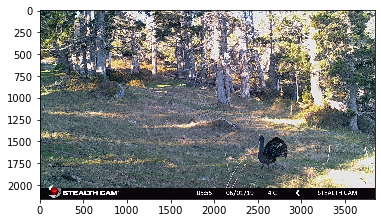

In [126]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

## Pre-processing

The `ImageDataGenerator` `keras`function allows to apply different treatments on the images (transformation, normalisation). This transformation allows to produce tranformation on the images without saving a lot of changed images on the disk. The transformations make the classifier more robust. As we did not have a lot of images with the tetrao urogallus, it allowed us to have more and thus train the algorithm better.

All the possible transformations are listed in the documentation of the function.

In [128]:
datagen = kpi.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In oder to visualize the transformed images, we will use the`.flow()` command that generates transformed images from an original image and saves them in the specified directory.

In the following code we produce 8 of these transformed images.

In [129]:
img = kpi.load_img(data_dir+"/train/presence/presence_t_0001.jpg")
x = kpi.img_to_array(img)  
x_ = np.expand_dims(x, axis=0)

if not(os.path.isdir(data_dir+"/preprocessing_example")):
    os.mkdir(data_dir+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir+"/preprocessing_example", save_prefix='bird', save_format='jpg'):
        i += 1
        if i > 7:
            break  

Display transformed images

<ipython-input-130-158b9f19a040>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("bird_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())


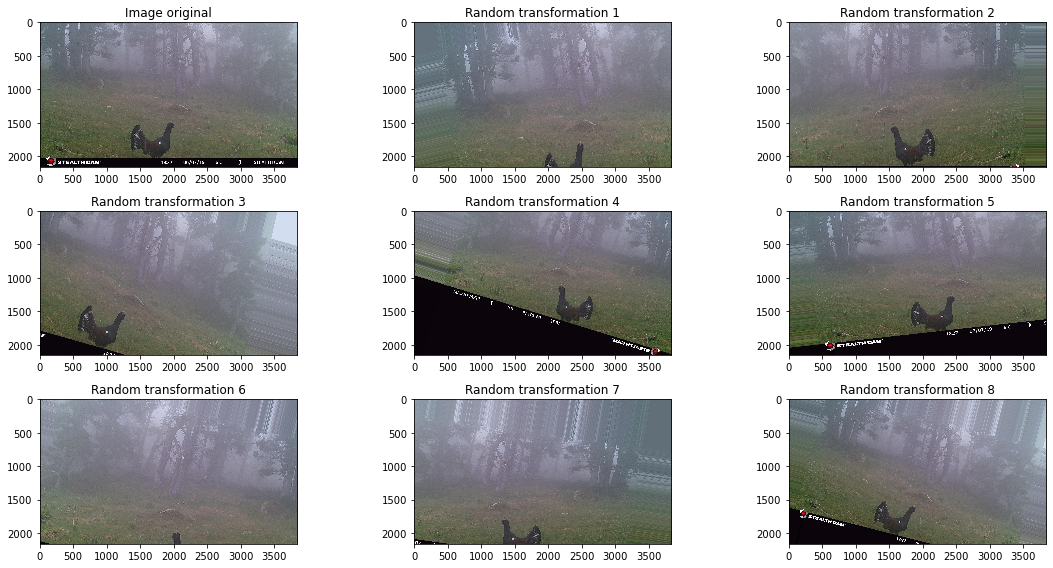

In [130]:
X_list=[]
for f in os.listdir(data_dir+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("bird_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## 1- Image classification from scratch with a convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

We first define epochs and batch_size parameters.

* `epochs`: we start with a small number (5-10) in order to check that computing time is reasonable.
* `batch_size`:When using keras Generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.


In [131]:
epochs = 20
batch_size=10

### Data Generation

We defined two `ImageDataGenerator` objects :

* `train_datagen`: for learning, where different transformations are applied as above, in order to pass various examples to the model.
* `valid_datagen`: for validation, where only rescaling is applied.


Images all have the same dimensions :

In [5]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir+"/train/presence/presence_t_0001.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir+"/train/presence/presence_t_0002.jpg"))
x_0.shape, x_1.shape

NameError: name 'kpi' is not defined

The `flow_from_directory` method allows to specify an output dimension in which all transformed images will be produced. We divided the dimensions for our images by ten to reduce the parameters of the algorithm.

In [133]:
img_width = 384
img_height = 216

In [134]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 318 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


### Model architecture

The model we define is composed of 3 convolution blocks with the following form : 

* A Conv2D layer with 32-3X3 filters and a `Relu` activation function.
* A MaxPooling layer with 2X2 window.

Followed by 


* A flatten layer.
* A Dense layer with 64 neurons and a Relu activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 1 neuron and a softmax activation function.

In [135]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 382, 214, 32)      896       
_________________________________________________________________
activation_30 (Activation)   (None, 382, 214, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 191, 107, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 189, 105, 32)      9248      
_________________________________________________________________
activation_31 (Activation)   (None, 189, 105, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 94, 52, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 92, 50, 64)       

As our problem here is a two classes classifier we will use the `binary_crossentropy` loss function.

In [136]:
model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



#### Training

The training can then be done by using the `fit_generator` function instead of the `fit` function used in the MNIST notebook. This function can be used by passing generator object instead of the data to the function

In [137]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs, 
                         validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning Time for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))


Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.9979 - accuracy: 0.5400 - val_loss: 0.7590 - val_accuracy: 0.4500
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.7226 - accuracy: 0.5600 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.6959 - accuracy: 0.6122 - val_loss: 0.6122 - val_accuracy: 0.7000
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.6401 - accuracy: 0.6500 - val_loss: 0.5437 - val_accuracy: 0.7000
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.7603 - accuracy: 0.6800 - val_loss: 0.6618 - val_accuracy: 0.7000
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.7062 - accuracy: 0.6000 - val_loss: 0.5717 - val_accuracy: 0.7000
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.5223 - accuracy: 0.7755 - val_loss: 0.9211 - val_accuracy: 0.4500
Epoch 8/20
10/10 [==

#### Prediction

In [138]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

10/10 [==============================] - 9s 945ms/step - loss: 0.2454 - accuracy: 0.8900
Train accuracy: 0.8899999856948853
Validation accuracy: 0.6000000238418579
Time Prediction: 17.22 seconds


## 2- Pre-trained Network

We have seen above that the complexity of the data makes it difficult to build quickly an efficient classifier from scratch even  with an elaborate method as a convolutional network.

We will now see that this problem can easily be tackled by using **pre-trained models**. These models are models that are very complex (see image below). They have been trained on a very huge amount of image data in order to classify them. 

The figure below represents a *VGG 16*. This model is composed of *5 convolutional blocks* which allows to build features on the images. The last block is a *fully convolutional block*. This last block can be seen as a simple *MLP model* which is used on the features build by the convolutional block.

Here is our two-stage strategy :  
1. We will send our data through the 5 convolutional blocks in order to build features. These blocks have been trained on a huge amount of data and can then build intelligent features.
2. We will build our own MLP classifier designed to solve our absence/presence problem, and we will train it on the features built on the first step.


### Network illustration

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

### Step 1 : Build features

#### Download  the weights of the 5 blocks convolutional layer.

We will now download the weights of a VGG16 model that has been learned on the [image-net](http://www.image-net.org) dataset. The image-net is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The *include_top* argument of the `VGG16` application allows to precise if we want to use or not the last block (fully-connected later)


In [147]:
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Building features

We will now send our data to the loaded model in order to build our features.

In [150]:
datagen = kpi.ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        data_dir+"/train",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  
features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)


generator = datagen.flow_from_directory(
    data_dir+"/validation",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)    

Found 318 images belonging to 2 classes.
16/16 [==============================] - 31s 2s/step
Found 78 images belonging to 2 classes.
4/4 [==============================] - 7s 2s/step


In [151]:
print(N_val)

40


### Step 2 :  Building our classifier on top of features

We will now build a simple classifier in order to use the previously build features to classify our data.


#### Training
**Exercise** Write this classifier 

In [154]:
# %load solutions/classifier_pretrained_model.py
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()


train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2359360   
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 2,359,425
Trainable params: 2,359,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
16/16 [==============================] - 0s 16ms/step - loss: 2.2301 - accuracy: 0.5312 - val_loss: 0.6639 - val_accuracy: 0.7750
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6908 - accuracy: 0.5562 -

We now save the weights of this classifier to be used later.

### Prediction

In [155]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

5/5 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9875
Train accuracy: 0.987500011920929
Validation accuracy: 0.675000011920929
Time Prediction: 0.16 seconds


In [6]:
model_VGG_fcm.save_weights(data_dir+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

NameError: name 'model_VGG_fcm' is not defined

## 3 - Fine Tuning

We have notably increased the performances of our model with a model that is really quick. We can continue to try to improve our results by modifying the small MLP classifier network we build. 
 
But to really improve our model, it would be nice to also change the weights of the previous layers in order to make them fit our problem.
This is possible and it's called FineTuning.

In this part we will then build a Model which is composed of the 5 convolutional block of the VGG model (with its weights learned on Image Net) and the classifier block we built (with the weights that we have learned previously).

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)

### Model creation.

We first download the model as done previously.

However, the model will be trained on our images, we then have to specify the input_shape of our data.


In [157]:
# build the VGG16 network
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
print('Model loaded.')

Model loaded.


We then build a classfier model like the one we built above and we load the learned weights.

In [158]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

top_model.load_weights(data_dir+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


Finally we assemble these two models

In [159]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 216, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 108, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 96, 128)      

### Freezed block

Our model is ready to be fine-tuned! 

However, as seen above it contains a huge number of parameters that our computer may not handle.

We will start by fine-tune only the last block of convolution of our classifier. 

This is possible by updating the trainable arguments of the layers that we don't want to be updated.

In [160]:
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False

### Generate Data

In [161]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 318 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


### Training

In [162]:
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit_generator(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts


Epoch 1/20
16/16 [==============================] - 48s 3s/step - loss: 0.9085 - accuracy: 0.5437 - val_loss: 0.7358 - val_accuracy: 0.3000
Epoch 2/20
16/16 [==============================] - 61s 4s/step - loss: 0.6896 - accuracy: 0.5188 - val_loss: 0.7182 - val_accuracy: 0.4750
Epoch 3/20
16/16 [==============================] - 54s 3s/step - loss: 0.6884 - accuracy: 0.5750 - val_loss: 0.7038 - val_accuracy: 0.3250
Epoch 4/20
16/16 [==============================] - 52s 3s/step - loss: 0.6552 - accuracy: 0.6139 - val_loss: 0.7133 - val_accuracy: 0.4250
Epoch 5/20
16/16 [==============================] - 51s 3s/step - loss: 0.6512 - accuracy: 0.6772 - val_loss: 0.7496 - val_accuracy: 0.4250
Epoch 6/20
16/16 [==============================] - 51s 3s/step - loss: 0.5795 - accuracy: 0.6899 - val_loss: 0.7215 - val_accuracy: 0.5750
Epoch 7/20
16/16 [==============================] - 52s 3s/step - loss: 0.5763 - accuracy: 0.6062 - val_loss: 0.6840 - val_accuracy: 0.4750
Epoch 8/20
16/16 [==

###  Prediction

In [163]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size, verbose=1)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size, verbose=1)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Validation accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

16/16 [==============================] - 32s 2s/step - loss: 0.2203 - accuracy: 0.9625
Train accuracy: 0.800000011920929
Validation accuracy: 0.9624999761581421
Time Prediction: 45.72 seconds
